In [191]:
import numpy as np
from scipy.fft import fftshift, ifftshift, fft2, ifft2
from scipy.stats import norm
import matplotlib.pyplot as plt

In [192]:
def designSurf(sigma, H, L, Nx, Ny, k_roll=None):
    """
    Generates artificial random rough surfaces with given parameters.

    Parameters (in SI units):
        sigma (float): Standard deviation (root-mean-square roughness).
        H (float): Hurst exponent (roughness exponent), 0<= H <= 1. It relates to the fractral dimension Df of the surface via H = 3 - Df.
        L (float): Length dimension of the surface.
        Nx (int): Number of pixels in x.
        Ny (int): Number of pixels in y.
        k_roll (float, optional): Cut-off wavevector or roll-off wave vector.
    
    Returns:
        z: Surface height profile of randomly rough surface (2D array).
        PixelWidth: Spatial resolution of the surface.
        PSD: Power spectral density (PSD) information (dictionary).
    """
    # ==============================================
    # make sure Nx and Ny are even
    Nx = Nx if Nx % 2 == 0 else Nx - 1
    Ny = Ny if Ny % 2 == 0 else Ny - 1
    
    # PixelWidth and surface lengths
    PixelWidth = L / Nx
    a = PixelWidth           # lattice constant
    
    Lx = Nx * PixelWidth
    Ly = Ny * PixelWidth
    
    # ==============================================
    # generate wave vectors kx and ky.
    # Note that k = 2*pi/lambda, where lambda is wavelength
    kx = (2 * np.pi / Nx) * np.arange(Nx)
    kx = (np.unwrap((fftshift(kx))-2 * np.pi))/a
    
    ky = (2 * np.pi / Ny) * np.arange(Ny)
    ky = (np.unwrap((fftshift(ky))-2 * np.pi))/a
    
    KX, KY = np.meshgrid(kx, ky)
    rho = np.hypot(KX, KY) # create radial grid, which is the radial distance from the centre in wave vector space
    
    # handle k_roll (roll-off wave vector)
    if k_roll is None:
        k_roll = 0 # default, no roll-off
    
    # ==============================================
    # create 2D matrix of Ck values
    Ck = np.zeros((Ny, Nx))
    for i in range(Nx):
        for j in range(Ny):
            if rho[j, i] < k_roll:
                Ck[j, i] = k_roll**(-2 * (H + 1))
            else:
                Ck[j, i] = rho[j, i]**(-2 * (H + 1))
    
    # ensure the scaling factor for the correct RMS roughness
    Ck[Ny//2, Nx//2] = 0  # remove mean
    
    # correct the RMS calculation by integrating over the PSD, normalized by area
    RMS_2D = np.sqrt(np.sum(Ck) * ( (2 * np.pi)**2 / (Lx * Ly) ))
    const = sigma / RMS_2D
    Ck *= const**2
    
    # ==============================================
    # radial averaging (PSD)
    Nk = 200 # resolution in k spaces
    kMin = np.log10(np.sqrt(((2 * np.pi / Lx)**2 + (2 * np.pi / Ly)**2)))
    kMax = np.log10(np.sqrt(kx[-1]**2 + ky[-1]**2))  # Nyquist limit
    k = np.floor(np.logspace(kMin, kMax, Nk))        # radial frequency bins
    
    C_MEAN = np.zeros(len(k) - 1)
    for i in range(len(k) - 1):
        ind = np.where( (rho > k[i]) & (rho <= k[i + 1]) )
        
        if len(ind[0]) > 0:
            C_MEAN[i] = np.nanmean(Ck[ind])
        else:
            C_MEAN[i] = np.nan
        
    valid = ~np.isnan(C_MEAN)
    k = k[:-1]       # reduce size of k to match the size of valid
    k = k[valid]
    C = C_MEAN[valid]
    
    # ==============================================
    # reverse PSD to get the magnitude in the frequency domain (PSD to fft)
    Bk = np.sqrt(Ck / (PixelWidth**2/ ((Ny*Nx) * ((2*np.pi)**2))))
    
    # apply conjugate symmetry to magnitude. This ensures that the inverse FFT will yield a real-valued surface by enforcing symmetry in both the magnitude and phase components.
    # set the corner and middle points of Bk to zero
    Bk[0, 0] = 0
    Bk[0, Nx//2] = 0
    Bk[Ny//2, Nx//2] = 0
    Bk[Ny//2, 0] = 0
    
    # apply conjugate symmetry to Bk
    Bk[1:, 1:Nx//2]    = np.rot90(Bk[1:, Nx//2+1:], 2)     # 2D array, rotation is fine
    Bk[0, 1:Nx//2]     = np.flip(Bk[0, Nx//2+1:])          # 1D array, using np.flip
    Bk[Ny//2+1:, 0]    = np.flip(Bk[1:Ny//2, 0])           # 1D array, using np.flip
    Bk[Ny//2+1:, Nx//2] = np.flip(Bk[1:Ny//2, Nx//2])      # 1D array, using np.flip
    
    # define random phase between -pi and pi
    phi = -np.pi + (2 * np.pi) * np.random.rand(Ny, Nx)
    
    # apply conjugate symmetry to phase
    phi[0, 0] = 0
    phi[0, Nx//2] = 0
    phi[Ny//2, Nx//2] = 0
    phi[Ny//2, 0] = 0
    
    # Apply conjugate symmetry to phase array
    phi[1:, 1:Nx//2]    = -np.rot90(phi[1:, Nx//2+1:], 2)     # 2D array, rotation is fine
    phi[0, 1:Nx//2]     = -np.flip(phi[0, Nx//2+1:])          # 1D array, using np.flip
    phi[Ny//2+1:, 0]    = -np.flip(phi[1:Ny//2, 0])           # 1D array, using np.flip
    phi[Ny//2+1:, Nx//2] = -np.flip(phi[1:Ny//2, Nx//2])      # 1D array, using np.flip
    
    # ==============================================
    # generate complex-valued Fourier coefficients
    a, b = np.cos(phi), np.sin(phi)
    Ha = Bk * (a + 1j * b)
    
    # ==============================================
    # generate the surface using inverse FFT
    z = np.real(ifft2(ifftshift(Ha)))
    
    # Prepare the PSD information for output
    PSD = {
        'kx': kx,
        'ky': ky,
        'Ck': Ck,
        'k': k,
        'C': C
    }

    return z, PixelWidth, PSD
    

In [193]:
def checkSpectrum_2D(z, PixelWidth):
    """
    Calculate radially averaged 2D power spectrum.

    Parameters:
        z (double): 2D numpy array
                    Height topography matrix (in SI units, e.g., metres).
        PixelWidth (double): float
                    Size of each pixel in the topography/image (in metres).
    Returns:
        k: numpy array
           wave vectors, which are 2pi/lambda, where lambda is the wavelength.
        C: numpy array
           Radially averaged power spectrum (2D PSD)
        PSD: dic
           Dictionary containing various PSD-related data (Ha, Ck, kx, ky, z_win)
    """
    # ==============================================
    # ensure the size is even
    Ny, Nx = z.shape
    if Ny % 2 !=0:
        z = z[1:, :] # remove the first row if Ny is odd
        Ny = Ny - 1
    if Nx % 2 !=0:
        z = z[:, 1:] # remove the first column is Nx is odd
        Nx = Nx - 1
    
    Lx = Ny * PixelWidth
    Ly = Nx * PixelWidth
    a  = PixelWidth  # pixel width (lattice spacing)
    
    # ==============================================
    # Window function (Welch window), which is used to taper the edges of the surface z, reducing edge effects in the FFT. This window multiplies the surface to gradually reduce values at the edges.
    win = (1 - (((np.arange(Ny)) - (Ny-1)/2)/((Ny+1)/2))**2)[:, None] * \
          (1 - (((np.arange(Nx)) - (Nx-1)/2)/((Nx+1)/2))**2)
          
    # rectangular window integral and Welch window integral (for normalization)
    recInt = np.trapezoid(np.trapezoid(np.ones((Ny, Nx))**2, axis=1), axis=0)
    winInt = np.trapezoid(np.trapezoid(win**2, axis=1), axis=0)
    const = winInt / recInt  # normalization constant
    
    # apply the window function to z
    z_win = z * win
    
    # ==============================================
    # calculate 2D PSD
    Ha = fftshift(fft2(z_win, s=(Ny, Nx)))  # 2D FFT of the windowed surface
    Ck = (1/const) * (a**2 / (Ny*Nx) / (2*np.pi)**2) * np.abs(Ha)**2
    Ck[Ny//2, Nx//2] = 0  # remove the mean value from the PSD
    
    # ==============================================
    # calculate the wave vectors after fftshift
    kx = (2 * np.pi / Nx) * np.arange(Nx)
    kx = (np.unwrap((fftshift(kx))-2 * np.pi))/a
    
    ky = (2 * np.pi / Ny) * np.arange(Ny)
    ky = (np.unwrap((fftshift(ky))-2 * np.pi))/a
    
    KX, KY = np.meshgrid(kx, ky)
    rho = np.hypot(KX, KY)
    
    # ==============================================
    # radial averaging (PSD)
    Nk = 200 # resolution in k spaces
    kMin = np.log10(np.sqrt(((2 * np.pi / Lx)**2 + (2 * np.pi / Ly)**2)))
    kMax = np.log10(np.sqrt(kx[-1]**2 + ky[-1]**2))  # Nyquist limit
    k = np.floor(np.logspace(kMin, kMax, Nk))        # radial frequency bins
    
    C_MEAN = np.zeros(len(k) - 1)
    for i in range(len(k) - 1):
        ind = np.where( (rho > k[i]) & (rho <= k[i + 1]) )
        
        if len(ind[0]) > 0:
            C_MEAN[i] = np.nanmean(Ck[ind])
        else:
            C_MEAN[i] = np.nan
        
    valid = ~np.isnan(C_MEAN)
    k = k[:-1]       # reduce size of k to match the size of valid
    k = k[valid]
    C = C_MEAN[valid]
    
    # ==============================================
    # store results in the PSD dictionary
    PSD = {
        'Ha': Ha,      # 2D FFT of the windowed surface
        'Ck': Ck,      # 2D power spectrum density
        'kx': kx,      # Wave vector in x direction
        'ky': ky,      # Wave vector in y direction
        'z_win': z_win # Windowed z profile
    }
    
    return k, C, PSD
    

Target RMS: 10, Actual RMS: 9.99990356250148


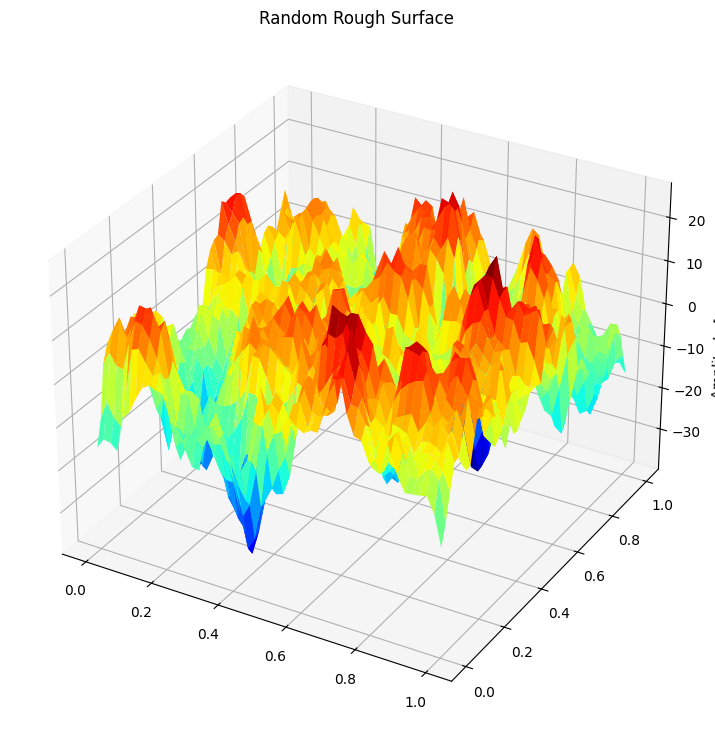

In [194]:
RMS = 10
H = 0.8 # for self-affin'e surface, D = 3 - H (three-diemsional arrays)
rolloff = 1 * 1e9  # roll-off wavevector for the surface

# reference length and constants
refLength = 1e-10  # metres to angstroms

# grid size and surface dimensions
Nx = 50
Ny = 50
Lx = 198 * refLength
Ly = 198 * refLength
A = Lx * Ly # area in square Angstroms

# generate meshgrid for plotting
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)

# generate the random rough surface
Rough, PixelWidth, PSD = designSurf(RMS, H, Lx, Nx, Ny, rolloff)

# calculate actual RMS of the generated surface to verify correctness
actual_RMS = np.sqrt(np.mean(Rough**2))
print(f"Target RMS: {RMS}, Actual RMS: {actual_RMS}")

# Plot the random rough surface
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Rough, cmap='jet')
ax.set_zlabel('Amplitude [Angstrom]')
ax.set_title('Random Rough Surface')
plt.show()

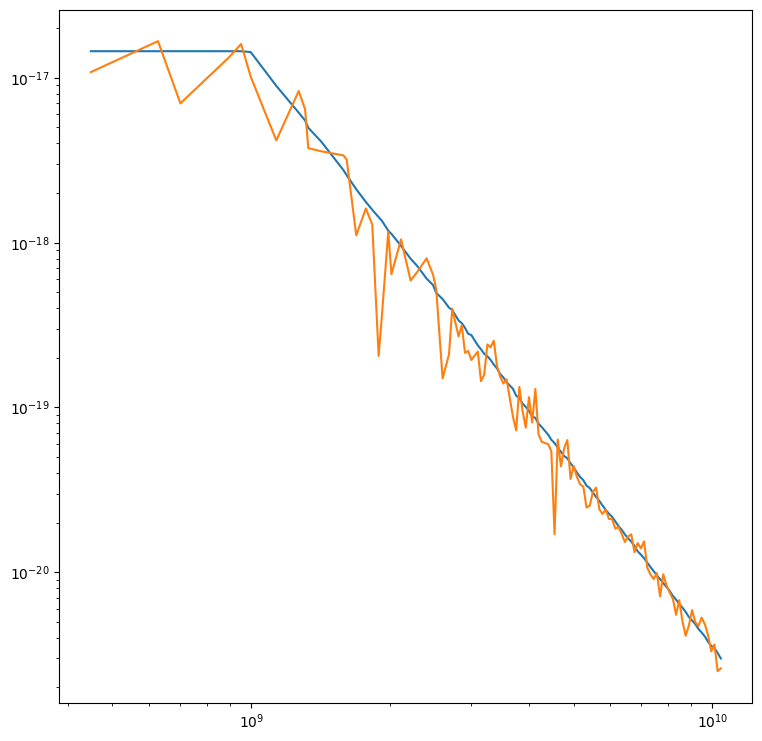

In [195]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_box_aspect(1)

# plot the theoretical (designed) power spectrum
ax.loglog(PSD['k'], PSD['C'])

k_real, C_real, PSD_real = checkSpectrum_2D(Rough, PixelWidth)
ax.loglog(k_real, C_real)